In [3]:
#!pip install yfinance 
#!pip install talib-binary
#!pip install hurst

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from pandas_datareader import data

import yfinance as yf
import talib as ta
from hurst import compute_Hc

# Import and filter warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.style.use('seaborn-darkgrid')

In [5]:
# define the variable parameters
ticker = 'MOS'
start_date = '2022-01-01'
end_date = '2022-3-25'

In [6]:
# Fetch the adjusted price data
# auto_adjust: Set this to True to download the adjusted price. By default, it is False.

data = yf.download(ticker, start_date, end_date, auto_adjust=True)
data.head() 

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2022-01-03,39.414327,40.462049,39.414327,40.102829,3798400
2022-01-04,40.561835,40.881141,40.032982,40.412159,4046400
2022-01-05,40.771379,41.060751,38.885479,38.915413,4815700
2022-01-06,39.394372,39.813463,37.927559,39.324524,3970000
2022-01-07,39.404351,40.232549,39.344480,40.092854,3934600


## **Technical Indicators**

**1) Simple Moving averages** - work only in a trending market. If the asset prices follows cyclic pattern without any trend - no signals.

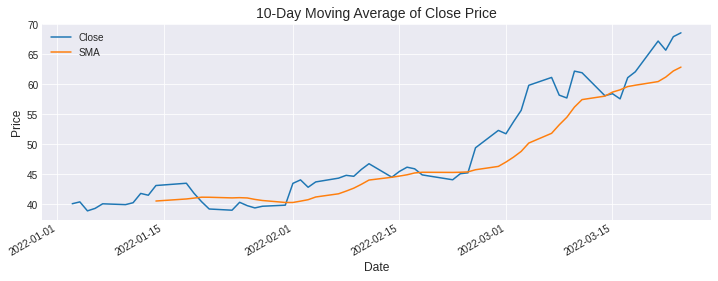

In [7]:
# Calculate simple moving average with window size 10
data['SMA'] = data['Close'].rolling(window=10).mean()

# Plot close price and 10-day moving average
data[['Close', 'SMA']].plot(figsize=(12, 4))
plt.title('10-Day Moving Average of Close Price', fontsize=14)
plt.ylabel('Price', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.show()

**2) Breakouts** - occur when a price jumps after a period of sideways, usually the result of an accumulation phase. <br>

* If *maximum price is at same level as closing price* level - closing price is increasing. This could imply a bull trend. 
* If *closing price dips below the maximum price* line, it could signal a bear trend.

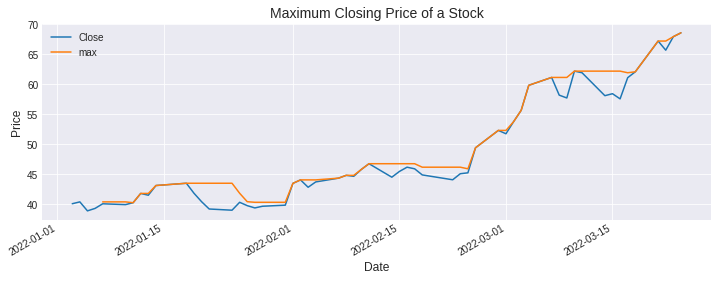

In [8]:
#Calculate rolling maximum close price
data['max'] = data.Close.rolling(window=5).max()

# Plot close price and rolling maximum close price
data[['Close','max']].plot(figsize=(12,4))
plt.title('Maximum Closing Price of a Stock', fontsize=14)
plt.ylabel('Price',fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.show()

# **Formulating the Trading Strategy**

In [38]:
# define the portoflio list
tickers = ['MOS', 'HUN', 'ATI', 'ARCC', 'CORN', 'VZ', 'LNT', 'GLD', 'GDX', 'SLV', 
           'SLVO', 'USOI', 'XLE', 'XME', 'MNRL', 'WY', 'CCJ', 'FNF', 'O', 'WPC',
           'SU', 'AAPL', 'CME', 'EPD', 'AAPL', 'TQQQ', 'APA', 'ICE', 'MP', 'MTB',
           'UNG', 'CPER', 'PBR', 'UVXY', 'MUR', 'NI', 'CENX', 'UFPI', 'MLI', 'SAFM' ]
start_date = '2019-01-01'
end_date = '2022-3-26'

In [39]:
# download adjusted closing price for the list of tickers
df = yf.download(tickers, start_date, end_date, auto_adjust=True)['Close'].round(2)
df.tail()

[*********************100%***********************]  39 of 39 completed


,AAPL,APA,ARCC,ATI,CCJ,CENX,CME,CORN,CPER,EPD,...,TQQQ,UFPI,UNG,USOI,UVXY,VZ,WPC,WY,XLE,XME
Date,,,,,,,,,,,,,,,,,,,,,
2022-03-21,165.38,40.88,20.52,26.44,29.27,27.09,250.76,26.75,28.55,24.56,...,52.79,87.70,17.44,5.66,15.09,51.10,80.02,39.19,76.13,60.91
2022-03-22,168.82,40.52,20.80,27.07,29.19,27.13,247.99,26.82,28.63,24.55,...,55.91,86.02,18.09,5.60,14.72,51.00,80.18,38.20,75.57,60.53
2022-03-23,170.21,40.71,20.50,27.97,29.04,29.18,246.79,26.99,29.15,24.99,...,53.55,83.78,18.03,5.77,14.65,50.97,79.79,38.15,76.87,61.62
2022-03-24,174.07,40.78,20.59,27.91,29.00,28.82,244.93,26.69,28.73,25.23,...,57.02,80.33,18.97,5.71,14.14,51.00,80.21,38.07,77.06,63.31
2022-03-25,174.72,41.53,20.83,27.91,28.76,28.34,247.72,26.88,28.61,25.47,...,56.93,80.04,19.49,5.77,13.59,51.28,81.53,38.60,78.75,63.33


**1) Identifying Stocks with Top Volatility Decile** <br>
From a portfolio, identify stocks with highest volatility deciles (i.e. splitting the stocks according to their volatility in 10 equal subsets, based on standard deviations). The highest volatility decile would be selected for creating a trading strategy.

In [40]:
# Calculate the daily percentage changes of the prices
df_pc = df.pct_change()
df_pc.tail()

# Calculate the standard deviation
# annualize the standard deviation and express it as a percentage 
df_std = df_pc.loc[start_date:end_date].std()*(252**0.5)*100
df_std_list = df_std.sort_values(ascending=False)

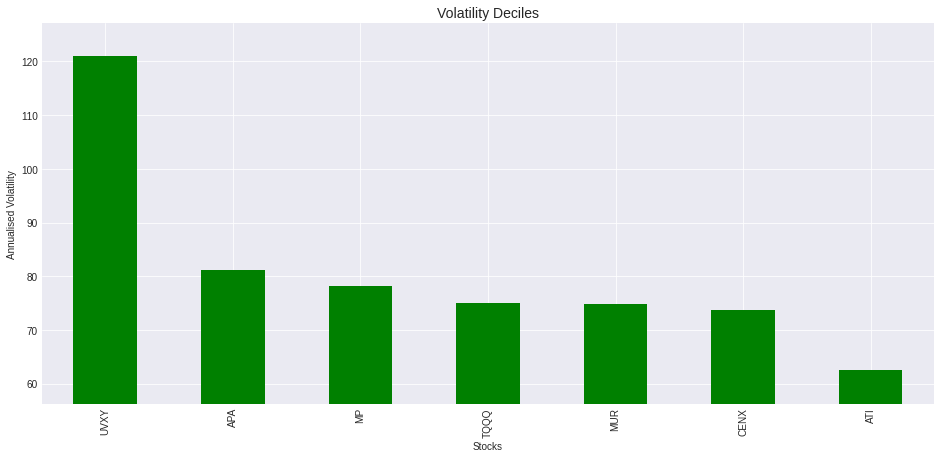

In [41]:
# Plotting/ Selecting Top 20% of the highest volatility into the portfolio
top_decile = df_std_list[:int(len(df_std_list)*0.2)] 
top_decile.plot.bar(figsize=(16,7),color='green',ylim=top_decile.min()*0.9)
plt.title('Volatility Deciles', fontsize=14)
plt.xlabel('Stocks')
plt.ylabel('Annualised Volatility')
plt.show()

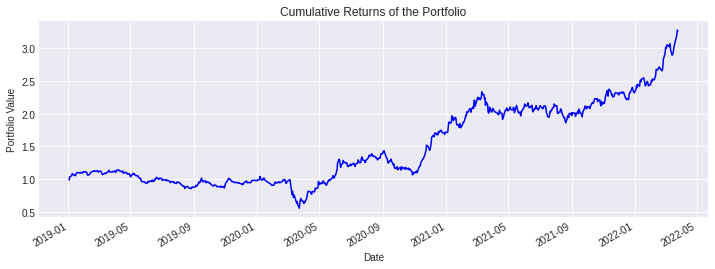

In [43]:
# Retrieve data in stock_list from 2019 January onwards
stock_data = df.loc['2019-1':,top_decile.index]

# Calculate the daily percentage change of prices
stock_data_pc = stock_data.pct_change()

# Create a new dataframe called portfolio
portfolio = pd.DataFrame()

# Calculate the average returns of stocks
portfolio['returns'] = stock_data_pc.mean(axis=1)

# Calculate cumulative returns of portfolio
portfolio['value'] = (portfolio+1).cumprod()

# Drop any rows with nan values
portfolio = portfolio.dropna()
portfolio.value.plot(color='b',figsize=(12,4))
plt.title('Cumulative Returns of the Portfolio')
plt.ylabel("Portfolio Value")
plt.show()

**2.1) Trading Signals - The Moving Average** <br>
When stock/ portfolio breaks out or breakds down of 10 DMA 

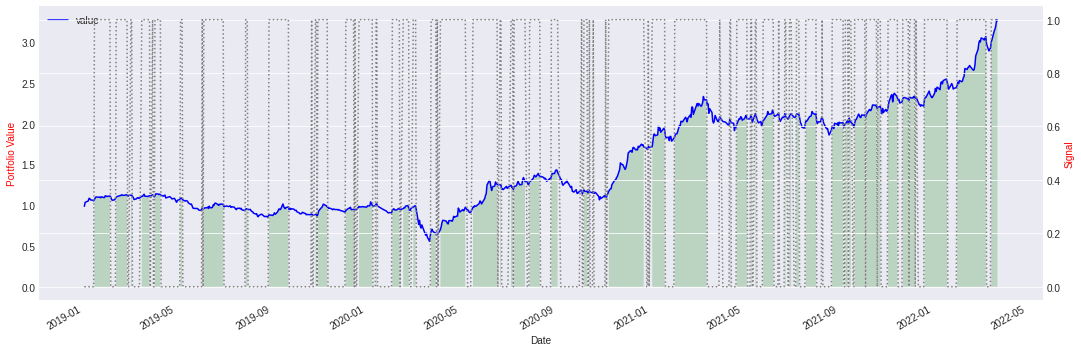

In [45]:
def get_strategy_returns_sma(portfolio):
    # Calculate the simple moving average of period 10
    portfolio['sma10'] = portfolio.value.rolling(window=10).mean()
    # Create a trading signal
    portfolio['signal'] = np.where(portfolio.value > portfolio.sma10,1,0)
    # Calculate the strategy returns
    portfolio['str_returns'] = portfolio['returns'].shift(-1) * portfolio['signal']
    return portfolio

def plot_signal(portfolio):
    portfolio['value'].plot(color='blue')    
    plt.fill_between(portfolio.index, portfolio.value, where=(portfolio.signal==1), facecolor='g', alpha=0.2)      
    plt.legend()
    plt.ylabel('Portfolio Value',color='r')
    # Plot the signal values    
    portfolio['signal'].plot(secondary_y=True,figsize=(18,6),color='grey', linestyle='dotted')
    plt.ylabel('Signal',color='r')
    plt.show()

portfolio = get_strategy_returns_sma(portfolio)    
plot_signal(portfolio)    

The Sharpe ratio is 1.49 


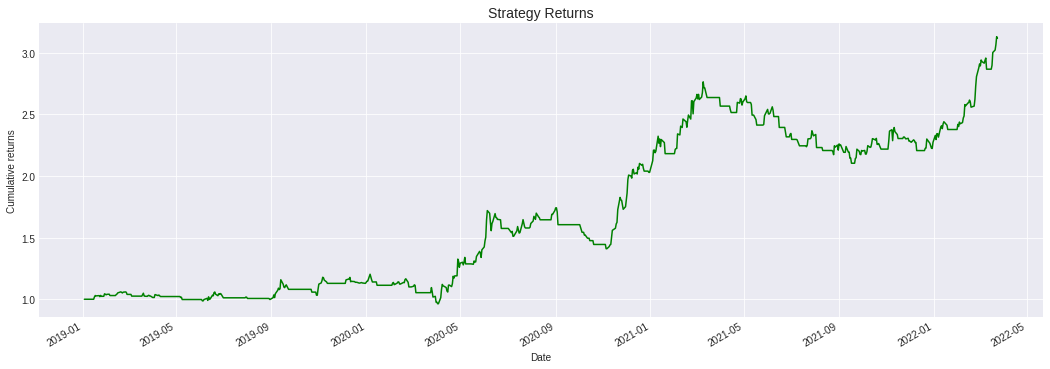

The maximum drawdown is -23.90


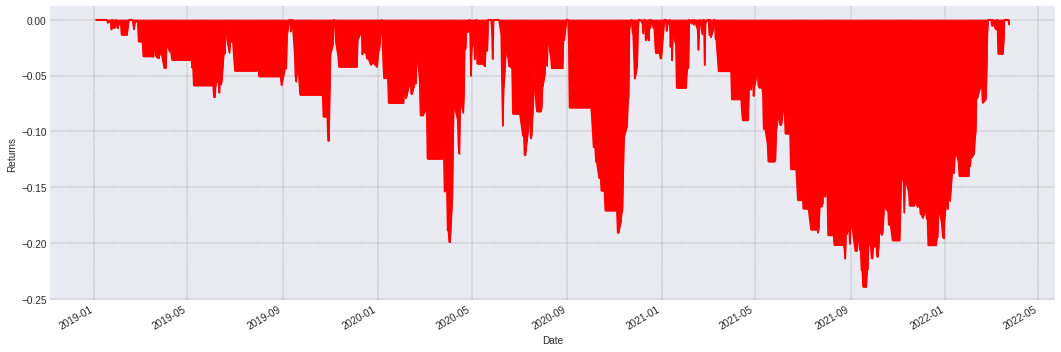

In [50]:
# Plot the portfolio returns
def plot_returns_dd(portfolio):
    # ----------- Sharpe ratio ------------------
    sharpe_ratio = np.mean(portfolio.str_returns)/np.std(portfolio.str_returns)*(252**0.5)
    print('The Sharpe ratio is %.2f ' % sharpe_ratio)

    # ----------- Cumulative strategy returns ------------------
    portfolio['cum_str_returns'] = (portfolio['str_returns']+1).cumprod()
    # Plot the cumulative strategy returns
    portfolio['cum_str_returns'].plot(figsize=(18, 6), color='green')
    plt.title('Strategy Returns', fontsize=14)
    plt.ylabel('Cumulative returns')
    plt.show()        

    # ----------- Drawdown ------------------    
    # Calculate the running maximum
    running_max = np.maximum.accumulate(portfolio['cum_str_returns'].dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = (portfolio['cum_str_returns'])/running_max - 1
    max_dd = drawdown.min()*100
    print('The maximum drawdown is %.2f' % max_dd)
    # Plot the drawdowns
    drawdown.plot(color='r',figsize=(18,6))
    plt.ylabel('Returns')
    plt.fill_between(drawdown.index, drawdown, color='red')
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
    plt.show()    
    
plot_returns_dd(portfolio)    

**2.2) Using Breakout + DMA Signal**

In [51]:
portfolio.head()

,returns,value,sma10,signal,str_returns,cum_str_returns
Date,,,,,,
2019-01-03,-0.012670,0.987330,NaN,0,0.0,1.0
2019-01-04,0.049037,1.035745,NaN,0,0.0,1.0
2019-01-07,0.012314,1.048499,NaN,0,0.0,1.0
2019-01-08,0.004162,1.052863,NaN,0,0.0,1.0
2019-01-09,0.030636,1.085119,NaN,0,-0.0,1.0


The Sharpe ratio is 1.53 


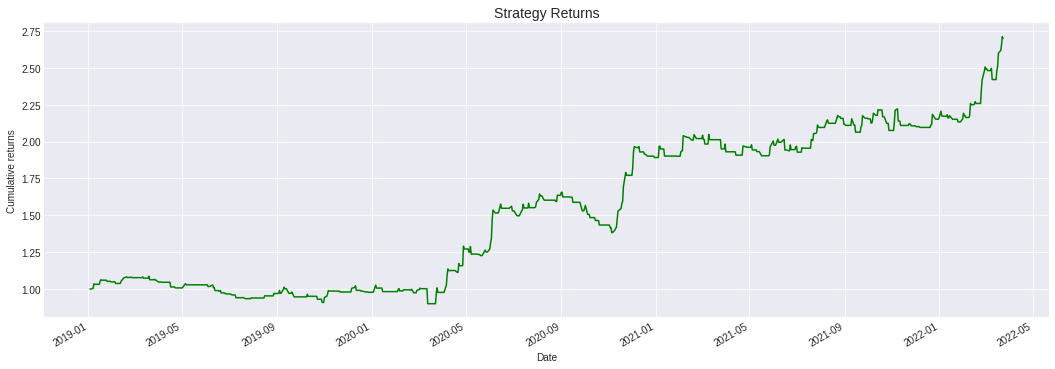

The maximum drawdown is -17.13


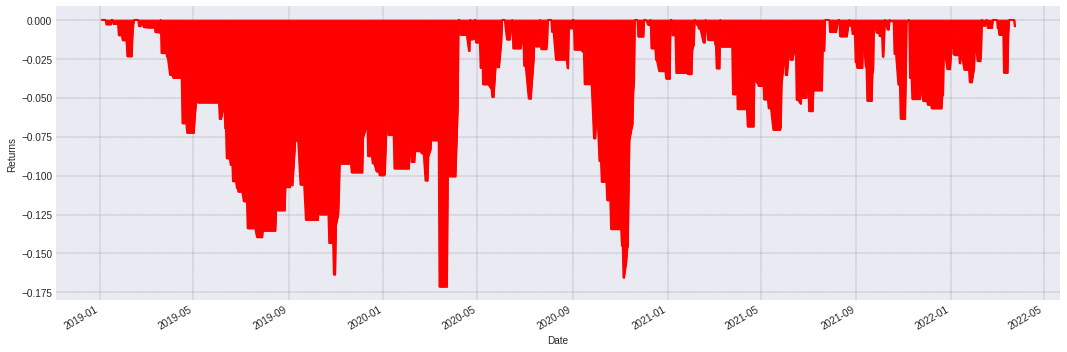

In [52]:
def get_strategy_returns_breakout(portfolio):
    # Calculate the breakout indicator values
    portfolio['high'] = portfolio.value.rolling(window=3).max()
    # Create a trading signal
    portfolio['signal'] = np.where(portfolio.value>=portfolio.high,1,0)
    # Calculate the strategy returns
    portfolio['str_returns'] = portfolio['returns'].shift(-1) * portfolio['signal']
    return portfolio

portfolio = get_strategy_returns_breakout(portfolio)
# plot_signal(portfolio)    
plot_returns_dd(portfolio)    

The Sharpe ratio is 1.59 


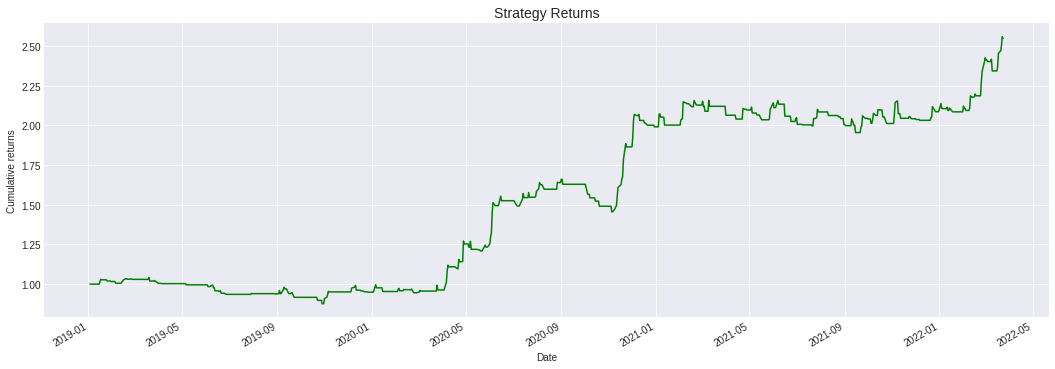

The maximum drawdown is -15.88


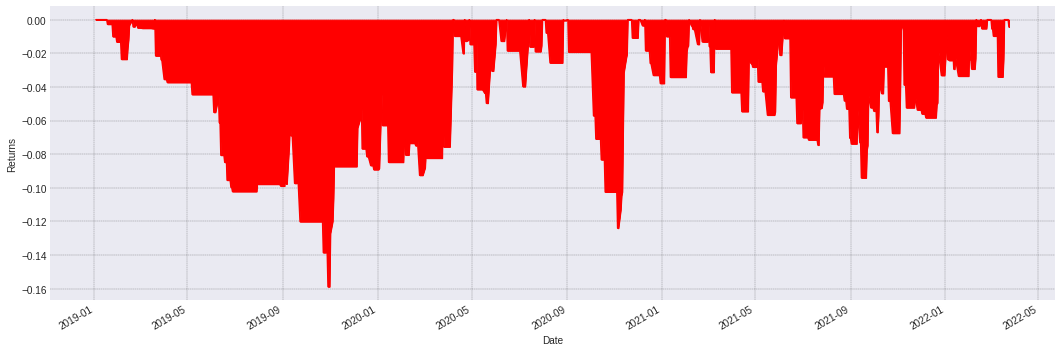

In [54]:
def get_strategy_returns_sma_breakout(portfolio):
    # Calculate the simple moving average 
    sma10 = portfolio.value > portfolio.value.rolling(window=10).mean()
    # Calculate the breakout indicator values
    breakout = portfolio.value>=portfolio.value.rolling(window=3).max()

    # Create a trading signal
    portfolio['signal'] = np.where(sma10 & breakout,1,0)

    # Calculate the strategy returns
    portfolio['str_returns'] = portfolio['returns'].shift(-1) * portfolio['signal']
    return portfolio

portfolio = get_strategy_returns_sma_breakout(portfolio)
# plot_signal(portfolio)    
plot_returns_dd(portfolio)    